# 🧪 Data Profiling Assignment — Analyst Skills in Practice


Welcome! This hands-on assignment mirrors how analysts explore and explain real data.
You’ll work with a synthetic dataset (thousands of rows) that mimics common shapes (normal,
lognormal, heavy-tailed, uniform, bimodal, and outlier-contaminated).  

**What you’ll practice**
- **Central tendency:** mean, median, (estimated) mode  
- **Dispersion:** variance, std, range, IQR, coefficient of variation (CV)  
- **Shape:** skewness, (excess) kurtosis, Q-Q plots  
- **Position & extremes:** percentiles, z-scores, outlier flags  
- **Rules:** Empirical Rule vs Chebyshev’s inequality  

Each question provides **two blank cells** (code + interpretation).  
This instructor version also includes clearly labeled **reference solutions** to show
professional presentation and optimized code patterns.


---

### Table of Contents


- 1) Setup  
- 2) Generate a sample dataset  
- 3) Helper utilities  
- **Section A** — Central Tendency  
- **Section B** — Dispersion  
- **Section C** — Shape of the Distribution  
- **Section D** — Position & Extremes  
- **Section E** — Distribution Rules  
- **Section F** — Synthesis & Communication  
- Submission Checklist


## 1) Setup

In [1]:

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Display & numeric hygiene
np.set_printoptions(suppress=True, edgeitems=3, linewidth=140)
pd.set_option('display.width', 140)
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:,.6f}'.format)


## 2) Generate a Sample Dataset (thousands of points)

In [2]:

# Reproducible synthetic data that covers diverse real-world shapes
rng = np.random.default_rng(42)
n = 5000

normal      = rng.normal(0, 1, n)                        # symmetric, light tails
lognormal   = rng.lognormal(mean=0.0, sigma=0.9, size=n) # positive, right-skewed
t_df3       = rng.standard_t(df=3, size=n)               # symmetric, heavy-tailed
uniform     = rng.uniform(-3, 3, size=n)                 # flat
exponential = rng.exponential(scale=1.0, size=n)         # positive, right-skewed
bimodal     = np.concatenate([rng.normal(-2, 0.5, n//2), rng.normal(2, 0.5, n - n//2)])

# Normal with a handful of extreme outliers injected
with_outliers = rng.normal(0, 1, n)
out_idx = rng.choice(n, size=12, replace=False)
with_outliers[out_idx] = rng.normal(0, 1, size=12) * 10

df = pd.DataFrame({
    "normal": normal,
    "lognormal": lognormal,
    "t_df3": t_df3,
    "uniform": uniform,
    "exponential": exponential,
    "bimodal": bimodal,
    "with_outliers": with_outliers
})

df.head()


,normal,lognormal,t_df3,uniform,exponential,bimodal,with_outliers
0,0.304717,0.792822,0.138433,-0.045096,2.049361,-2.145103,-0.651898
1,-1.039984,0.763733,-0.229852,2.703969,1.891653,-1.722417,-1.579549
2,0.750451,0.534195,4.519477,1.059963,2.327707,-2.224025,0.646698
3,0.940565,1.470547,0.611817,0.513368,1.365464,-2.376502,-0.319862
4,-1.951035,1.235137,0.332825,-1.044643,0.389808,-2.328547,-1.262942


**Quick profile**

In [3]:
df.describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
normal,"5,000.000000",-0.019877,0.999454,-3.648413,-2.344475,-1.686511,-0.691954,-0.004161,0.631247,1.616243,2.374687,3.454046
lognormal,"5,000.000000",1.515106,1.746572,0.019251,0.116605,0.224248,0.551296,0.982112,1.831378,4.482198,8.258292,37.458799
t_df3,"5,000.000000",0.028603,1.652612,-12.577299,-4.427467,-2.278996,-0.742290,0.010486,0.765586,2.363684,4.744346,30.190838
uniform,"5,000.000000",0.038330,1.719777,-2.999717,-2.938160,-2.692716,-1.448413,0.029373,1.530037,2.704400,2.939962,2.999743
exponential,"5,000.000000",0.995986,0.993266,0.000030,0.008760,0.053553,0.278624,0.696891,1.374293,2.984003,4.558181,7.766503
bimodal,"5,000.000000",-0.011055,2.053284,-3.798815,-3.026646,-2.645437,-2.000615,0.003059,1.972950,2.635166,3.012465,4.163460
with_outliers,"5,000.000000",0.013223,1.130575,-5.917001,-2.428496,-1.643719,-0.667940,-0.001768,0.673869,1.597652,2.322361,20.732260


> Optional: Save a snapshot CSV for reproducibility.

In [4]:

df.to_csv("sample_data.csv", index=False)
print("Saved: sample_data.csv")


Saved: sample_data.csv


## 3) Helper Utilities (Reusable)

In [5]:
def coefficient_of_variation(x: pd.Series) -> float:
    """
    CV = sample std / mean (returns NaN when mean≈0).
    Prefer for strictly-positive metrics (e.g., times, amounts, sizes).
    """
    m = x.mean()
    s = x.std(ddof=1)
    return np.nan if np.isclose(m, 0.0) else s / m

def empirical_within_k(x: pd.Series, k: int) -> float:
    """Share of points within k standard deviations of the sample mean."""
    m, s = x.mean(), x.std(ddof=1)
    if np.isclose(s, 0.0):
        return np.nan
    z = (x - m) / s
    return (np.abs(z) <= k).mean()

def chebyshev_lower_bound(k: int) -> float:
    """Chebyshev bound: P(|X - μ| ≤ kσ) ≥ 1 - 1/k², for k ≥ 1 (distribution-free)."""
    assert k >= 1
    return 1 - 1 / (k**2)

def z_scores(x: pd.Series) -> pd.Series:
    """Sample z-scores (ddof=1)."""
    return (x - x.mean()) / x.std(ddof=1)

def estimated_mode_from_hist(x: pd.Series, bins: int = 50) -> float:
    """
    Rough mode estimate: midpoint of the most populated histogram bin.
    Works across many shapes; robust enough for quick profiling.
    """
    counts, bin_edges = np.histogram(x, bins=bins)
    idx = counts.argmax()
    return (bin_edges[idx] + bin_edges[idx+1]) / 2

def hist_and_qq(x: pd.Series, bins: int = 50, title: str = ""):
    """
    Quick shape visuals. Run as needed.
    (Do not set explicit colors or styles — keep defaults for reproducibility.)
    """
    plt.figure()
    plt.hist(x.values, bins=bins)
    plt.title(f"Histogram: {title}")
    plt.xlabel("value"); plt.ylabel("count")
    plt.show()

    plt.figure()
    stats.probplot(x, dist="norm", plot=plt)
    plt.title(f"Normal Q-Q: {title}")
    plt.show()


# Section A — Central Tendency

### A1. Mean vs Median (and an estimate of Mode)


Pick **two columns** — one roughly symmetric (e.g., `normal`) and one skewed (e.g., `lognormal` or `exponential`).

1) Compute **mean** and **median** for each.  
2) Provide a **rough estimate of the mode** (use `estimated_mode_from_hist`).  
3) Explain the **ordering** (mean vs median vs mode) and what it implies about **symmetry/skewness**.  
4) In a business context, when would you prefer **median** over **mean**, and why?


In [6]:
# 👇 Your code here

_Use this cell for your interpretation / short write-up._

**Instructor Reference — A1 Solution**

In [7]:
cols = ["normal", "lognormal"]
summary = []
for c in cols:
    s = df[c]
    row = {
        "column": c,
        "mean": s.mean(),
        "median": s.median(),
        "mode_est": estimated_mode_from_hist(s, bins=60)
    }
    summary.append(row)

pd.DataFrame(summary).set_index("column")

,mean,median,mode_est
column,,,
normal,-0.019877,-0.004161,0.317127
lognormal,1.515106,0.982112,0.331247


**Professional interpretation:**  
- For `normal`, mean ≈ median ≈ mode (symmetry).  
- For `lognormal`, **mode < median < mean** (right-skew): high positive tail pulls the mean up most.  
**When to prefer median:** with skewed or outlier-prone metrics (e.g., income, response times), the median
better represents a “typical” case and resists extreme values.

### A2. Robustness to Outliers


Using `with_outliers`:

1) Compute the mean and median **before** and **after** trimming the top/bottom 1% (use percentiles).  
2) Which statistic is **more robust** to the injected extremes? Explain.  
3) Why might stakeholders be misled by the mean here? Provide a short note.


In [8]:
# 👇 Your code here

_Use this cell for your interpretation / short write-up._

**Instructor Reference — A2 Solution**

In [9]:
s = df["with_outliers"]
lo, hi = s.quantile([0.01, 0.99])
trimmed = s[(s >= lo) & (s <= hi)]

res = pd.DataFrame({
    "metric": ["mean", "median"],
    "original": [s.mean(), s.median()],
    "trim_1pct_each_side": [trimmed.mean(), trimmed.median()]
}).set_index("metric")
res

,original,trim_1pct_each_side
metric,,
mean,0.013223,0.000714
median,-0.001768,-0.001768


**Professional interpretation:**  
- The **mean** shifts substantially after trimming (sensitive to extremes).  
- The **median** barely moves (robust).  
Stakeholders may be misled by the mean because a few extreme events inflate the “average”, masking the typical experience.

# Section B — Dispersion (Spread)

### B1. Variance, Standard Deviation, Range, and IQR


For **at least three columns** (suggestion: `normal`, `t_df3`, `with_outliers`):

1) Compute **variance**, **std**, **range** (max−min), and **IQR** (Q3−Q1).  
2) Interpret how **outliers** and **heavy tails** change these measures.  
3) Who would care about this in practice (e.g., risk, ops, product)?


In [10]:
# 👇 Your code here

_Use this cell for your interpretation / short write-up._

**Instructor Reference — B1 Solution**

In [11]:
cols = ["normal", "t_df3", "with_outliers"]
out = []
for c in cols:
    s = df[c]
    q1, q3 = s.quantile([0.25, 0.75])
    out.append({
        "column": c,
        "variance": s.var(ddof=1),
        "std": s.std(ddof=1),
        "range": s.max() - s.min(),
        "IQR": q3 - q1
    })
pd.DataFrame(out).set_index("column")

,variance,std,range,IQR
column,,,,
normal,0.998909,0.999454,7.102459,1.323201
t_df3,2.731127,1.652612,42.768137,1.507876
with_outliers,1.278199,1.130575,26.649261,1.341809


**Professional interpretation:**  
- **Heavy tails** (`t_df3`) inflate variance/std relative to a normal with similar center.  
- **Outliers** (`with_outliers`) explode **range** and elevate **std/variance**; IQR grows less since it’s percentile-based.  
**Who cares:** risk teams (tail risk), operations (process variability), product/CS (customer experience volatility).

### B2. Coefficient of Variation (CV)


For **positive-valued** columns (e.g., `lognormal`, `exponential`):

1) Compute **CV = std/mean**.  
2) Rank the selected columns by CV.  
3) Explain when CV is **not appropriate** (hint: mean≈0 or sign changes).


In [12]:
# 👇 Your code here

_Use this cell for your interpretation / short write-up._

**Instructor Reference — B2 Solution**

In [13]:
cols = ["lognormal", "exponential"]
cv = pd.Series({c: coefficient_of_variation(df[c]) for c in cols}, name="CV").sort_values(ascending=False)
cv.to_frame()

,CV
lognormal,1.152772
exponential,0.997269


**Professional interpretation:**  
- Higher CV ⇒ greater relative variability to the mean (risk per unit of return/cost).  
- CV is **not appropriate** when the mean is near zero or values cross zero (ratio becomes unstable/meaningless).

# Section C — Shape of the Distribution

### C1. Skewness & Kurtosis


Across **all columns**:

1) Compute **skewness** and **(excess) kurtosis** (`scipy.stats.kurtosis(..., fisher=True)`).  
2) Identify which are **right/left-skewed**.  
3) Which have **heavy tails** (excess kurtosis > 0)? What shows up in the Q-Q plot?


In [14]:
# 👇 Your code here

_Use this cell for your interpretation / short write-up._

**Instructor Reference — C1 Solution**

In [15]:
cols = df.columns.tolist()
shape = []
for c in cols:
    s = df[c]
    shape.append({
        "column": c,
        "skew": stats.skew(s, bias=False),
        "excess_kurtosis": stats.kurtosis(s, fisher=True, bias=False)
    })
pd.DataFrame(shape).set_index("column").sort_values("excess_kurtosis", ascending=False)

,skew,excess_kurtosis
column,,
lognormal,5.131989,56.754461
with_outliers,2.975650,46.378983
t_df3,1.544861,31.274059
exponential,1.865222,4.611082
normal,0.002143,0.037397
uniform,-0.023694,-1.186323
bimodal,0.003497,-1.765136


**Professional interpretation:**  
- Right-skew: `lognormal`, `exponential` (long positive tail).  
- Near-symmetric: `normal`, `t_df3` (though `t_df3` has **heavy tails**, excess kurtosis > 0).  
- Bimodal shape isn’t captured well by skew/kurtosis alone — Q-Q plots show deviations from a straight line (especially in tails).

### C2. Visual Intuition Check


Pick **two columns** with different shapes (e.g., `normal` vs `bimodal`).

1) Plot a histogram and a normal Q-Q plot for each (`hist_and_qq`).  
2) Explain why percentiles or averages alone can miss **multimodality**.


In [16]:
# 👇 Your code here

_Use this cell for your interpretation / short write-up._

**Instructor Reference — C2 Solution**

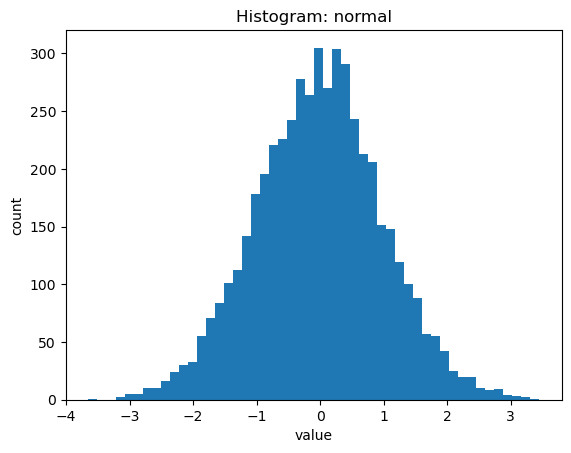

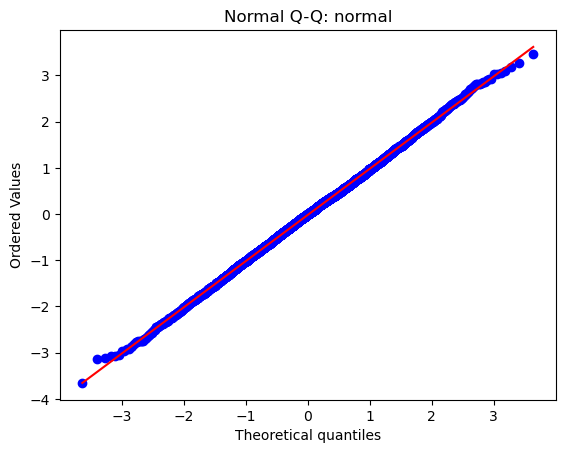

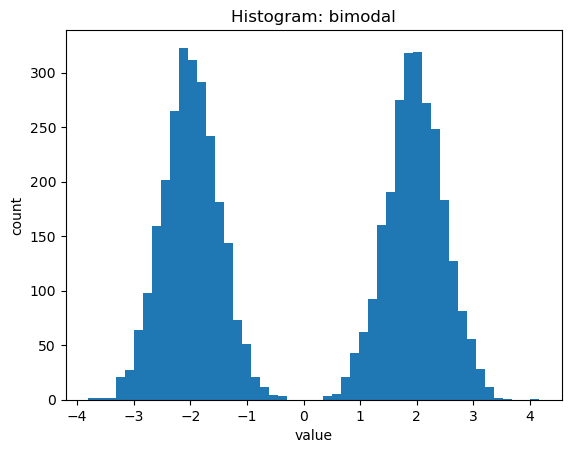

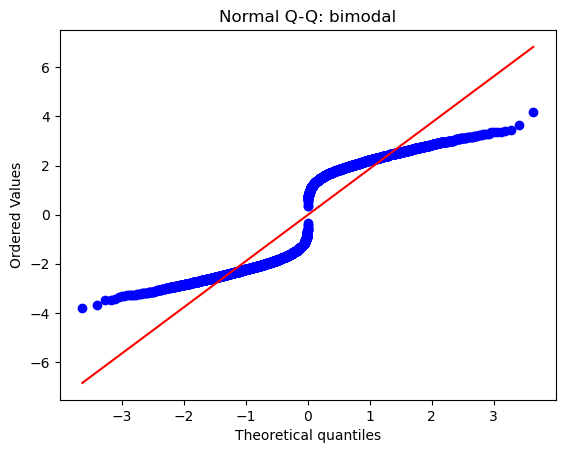

In [17]:
hist_and_qq(df["normal"], title="normal")
hist_and_qq(df["bimodal"], title="bimodal")

**Professional interpretation:**  
- Averages/percentiles condense information and can hide **multiple clusters** (bimodality).  
- Visuals reveal two distinct peaks even when central tendency metrics look innocuous.

# Section D — Position & Extremes

### D1. Min/Max & Percentiles


For **each column**:

1) Report **min**, **max**, and key **percentiles** (1st, 5th, 25th, 50th, 75th, 95th, 99th).  
2) Which columns show the **widest** 1st–99th percentile gap?  
3) What operational risks might that imply?


In [18]:
# 👇 Your code here

_Use this cell for your interpretation / short write-up._

**Instructor Reference — D1 Solution**

In [19]:
qs = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
rows = []
for c in df.columns:
    s = df[c]
    q = s.quantile(qs).to_dict()
    rows.append({
        "column": c,
        "min": s.min(),
        **{f"p{int(k*100)}": v for k, v in q.items()},
        "max": s.max(),
        "p01_99_spread": q[0.99] - q[0.01]
    })
res = pd.DataFrame(rows).set_index("column").sort_values("p01_99_spread", ascending=False)
res

,min,p1,p5,p25,p50,p75,p95,p99,max,p01_99_spread
column,,,,,,,,,,
t_df3,-12.577299,-4.427467,-2.278996,-0.742290,0.010486,0.765586,2.363684,4.744346,30.190838,9.171813
lognormal,0.019251,0.116605,0.224248,0.551296,0.982112,1.831378,4.482198,8.258292,37.458799,8.141687
bimodal,-3.798815,-3.026646,-2.645437,-2.000615,0.003059,1.972950,2.635166,3.012465,4.163460,6.039112
uniform,-2.999717,-2.938160,-2.692716,-1.448413,0.029373,1.530037,2.704400,2.939962,2.999743,5.878122
with_outliers,-5.917001,-2.428496,-1.643719,-0.667940,-0.001768,0.673869,1.597652,2.322361,20.732260,4.750857
normal,-3.648413,-2.344475,-1.686511,-0.691954,-0.004161,0.631247,1.616243,2.374687,3.454046,4.719161
exponential,0.000030,0.008760,0.053553,0.278624,0.696891,1.374293,2.984003,4.558181,7.766503,4.549420


**Professional interpretation:**  
Columns with the largest **p01–p99 spread** exhibit the widest “typical” variability.
This signals planning risk (buffering, SLAs), pricing risk (extremes), or resource risk (peak loads).

### D2. Z-Scores & Outlier Flagging


Using `with_outliers`:

1) Compute **z-scores** and count points with **|z| > 3**.  
2) Show the **indices** (or values) of these potential outliers.  
3) Explain the difference between **statistical outliers** and **bad data**.


In [20]:
# 👇 Your code here

_Use this cell for your interpretation / short write-up._

**Instructor Reference — D2 Solution**

In [21]:
s = df["with_outliers"]
z = z_scores(s)
mask = z.abs() > 3
out_idx = np.where(mask)[0]
summary = {
    "count_gt_3sd": int(mask.sum()),
    "fraction": float(mask.mean())
}
print(summary)
s.loc[mask].head(20)  # peek

{'count_gt_3sd': 19, 'fraction': 0.0038}


85      5.690295
553    -5.917001
688    -3.453305
1182   -3.516856
1336   -3.880246
1430   16.522891
1719   20.732260
1819   -3.792258
1856   -3.552507
2055   10.940303
2502   -3.497716
2595    5.665532
2627    5.007235
3181   17.353709
3185   -3.390723
3580   -3.451370
3760   10.433498
3847    9.650871
4345    3.867607
Name: with_outliers, dtype: float64

**Professional interpretation:**  
- **Statistical outliers**: extreme but potentially valid observations (e.g., real spikes).  
- **Bad data**: errors (entry, sensor, ETL). Treat outliers with context — investigate before removing, and document your criteria.

# Section E — Distribution Rules

### E1. Empirical Rule (68–95–99.7)


For `normal` and `t_df3`:

1) Compute proportions within **1, 2, 3** SDs of the mean.  
2) Compare vs **68%/95%/99.7%**. Where does it **match or break down**, and why?  
3) What mistakes happen if someone assumes normality where it doesn’t hold?


In [22]:
# 👇 Your code here

_Use this cell for your interpretation / short write-up._

**Instructor Reference — E1 Solution**

In [23]:
def within_k_report(s):
    return pd.Series({
        "k=1": empirical_within_k(s, 1),
        "k=2": empirical_within_k(s, 2),
        "k=3": empirical_within_k(s, 3)
    })

res = pd.DataFrame({
    "normal": within_k_report(df["normal"]),
    "t_df3": within_k_report(df["t_df3"])
})
res

,normal,t_df3
k=1,0.686000,0.812200
k=2,0.953200,0.957000
k=3,0.997400,0.984400


**Professional interpretation:**  
- `normal` ≈ 68/95/99.7 as expected.  
- `t_df3` typically has **fewer** points within k SDs (heavier tails).  
Assuming normality on heavy-tailed data **underestimates tail risk**, leading to brittle SLAs or insufficient buffers.

### E2. Chebyshev’s Inequality (distribution-free)


Pick any **three columns**:

1) For **k = 2, 3**, compute Chebyshev’s **lower bound** (≥ 1 − 1/k²) for proportion within k SDs.  
2) Compute the **actual proportions** and compare.  
3) Explain why Chebyshev can be **loose** yet **useful**.


In [24]:
# 👇 Your code here

_Use this cell for your interpretation / short write-up._

**Instructor Reference — E2 Solution**

In [25]:
cols = ["lognormal", "t_df3", "with_outliers"]
records = []
for c in cols:
    s = df[c]
    for k in (2, 3):
        records.append({
            "column": c, "k": k,
            "chebyshev_lower_bound": chebyshev_lower_bound(k),
            "actual_within_k": empirical_within_k(s, k)
        })
pd.DataFrame(records).pivot(index="column", columns="k", values=["chebyshev_lower_bound","actual_within_k"])

chebyshev_lower_bound          actual_within_k         
k                                 2        3               2        3
column                                                               
lognormal                  0.750000 0.888889        0.963000 0.984400
t_df3                      0.750000 0.888889        0.957000 0.984400
with_outliers              0.750000 0.888889        0.974800 0.996200

**Professional interpretation:**  
Chebyshev is **conservative** (loose) but **distribution-free** (works without normality).  
It gives a guaranteed floor when you can’t assume shape — valuable for worst-case planning and policy guarantees.

# Section F — Synthesis & Communication

### F1. Tell the Data Story


Choose **two** contrasting columns (e.g., `lognormal` vs `t_df3`).

Write a short **executive note** (5–10 sentences) explaining:
- **Typical** value (and why median vs mean)  
- **Spread/volatility** summary  
- **Shape/tails** and planning implications  
- **Extremes** (1–5% worst cases)  
- **Actionable recommendations** (monitoring, guardrails, buffers)


In [26]:
# 👇 Your code here

_Use this cell for your interpretation / short write-up._

**Instructor Reference — F1 Solution (Reference Narrative)**

**Executive note (example):**  
The `lognormal` metric is right-skewed; a small share of high values lifts the mean above the median, 
so the **median** is the more representative typical value. Its relative variability (CV) is moderate, 
but rare spikes (p95–p99) are materially higher than the median; we recommend reporting both median and p95 
to set realistic expectations.  

By contrast, `t_df3` is approximately symmetric around its center but **heavy-tailed**; while the mean/median align,
tail risk (more frequent extremes) is higher than under a normal assumption. Planning that assumes normality
will under-buffer capacity; for robust operations, size buffers using empirical p95/p99 and monitor tail events.
We recommend using percentile SLAs, with alerts when tail frequencies exceed thresholds.

---

### Submission Checklist


- ✅ Run all cells in order.  
- ✅ Provide a short interpretation after each question.  
- ✅ If you add visuals or helpers, justify briefly (what insight they add).  
- ✅ When handling outliers, **state your rule** and keep it consistent.  
- ✅ Prefer median/percentiles for skewed or outlier-prone metrics.  
- ✅ When in doubt about distributional shape, **don’t assume normality** — use Chebyshev or empirical percentiles.
